# Importando os dados

In [1]:
import requests,json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as pd
import numpy as np
import pymysql.cursors

C:\Users\andres\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


### Transformada do Cosseno

In [2]:
import math, time
def dct(p):
    n = len(p)
    mat = []
    suma = 0
    cte=math.sqrt(2/n)
    cf = 0
    for i in range(n):
        if i==0: cf = 1/math.sqrt(2)
        else: cf = 1
        for t in range(n):
            theta = ((2*t+1)*i*math.pi)/(2*n)
            suma = suma + p[t]*math.cos(theta)
        suma = cf*suma*cte
        mat.append(np.round(suma, decimals=3))
        suma = 0
    return mat

def idct(g):
    n = len(g)
    cte = math.sqrt(2/n)
    imat = []
    suma = 0
    cj = 0
    for i in range(n):
        suma = 0
        for t in range(n):
            if t==0: cj=1/math.sqrt(2)
            else: cj=1
            theta = ((2*i+1)*t*math.pi)/(2*n)
            suma = suma + cj*g[t]*math.cos(theta)
        suma = suma*cte
        imat.append(np.round(suma, decimals=3))
    return imat

## Lidando com os dados

In [42]:
#Função para realizar a conexao


#Função para importar os dados
def import_data_tec(ano_i: int,ano_f: int, lat: float):
    try:
        banco=pymysql.connect(
            host='ao9moanwus0rjiex.cbetxkdyhwsb.us-east-1.rds.amazonaws.com',
            user='t16zc09ibyggonsr',
            password='ujx5bfilxtmxn282',
            db='pzhisapgb2dhiyjr',
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
    except:
        print('error ao conectar com o banco de dados local')
    
    dic = []
    dias = 365
    try:
        for ano in range(ano_i, ano_f+1):
            with banco.cursor() as cursor:
                tbl_nome = str(ano)+"_"+str(float(lat))
                sql = "SELECT * FROM `"+tbl_nome+"` ORDER BY id LIMIT 0,"+str(dias*13)
                cursor.execute(sql)
                dic = dic + cursor.fetchall()
                
    except ValueError:
        print('Resposta inválida')
        return 0
    
    return dic

def import_data(ano_i: int, ano_f: int):
    F107 = []
    RSN = []
    factor = 0
    dias = 365
    for ano in range(ano_i,ano_f+1):
        parameters_datas = {"ano": ano, "dia_i": 1,"dia_f": dias}
        response = requests.get("https://tecdatas.herokuapp.com/f107", params=parameters_datas)
        F107 = F107 + response.json()
        parameters_datas = {"ano": ano, "dia_i": 1,"dia_f": dias}
        response = requests.get("https://tecdatas.herokuapp.com/rsn", params=parameters_datas)
        RSN = RSN + response.json()
        factor += 1
        
    return F107, RSN

# Função para filtrar os dados
def filtra_dados(ano_i: int, ano_f: int, lon: int, dic: list, F107: list, RSN: list):
    dados = []
    dias = 365
    f107 = []
    rsn = []
    step = 0
    factor = ano_f-ano_i + 1
    
    #Selecionando os dados para uma dada longitude
    for i in range(13*dias*factor):
            dados.append(dic[i][str(lon)])#Longitude -50.0

    #Criando e colocando o F10.7 e RSN em uma lista
    for ano in range(ano_i,ano_f+1):
        for f in range(step, step+365):
            f107.append(F107[f][str(ano)])
        step=step+365
        
    step = 0
    for ano in range(ano_i,ano_f+1):
        for f in range(step, step+365):
            rsn.append(RSN[f][str(ano)])
        step=step+365
    
    return dados,f107,rsn

# Função para salvar os dados em um dataFrame
def salva_dataframe(ano_i:int, ano_f:int, dados: list, f107: list, rsn: list):
    index = ['coef '+str(i) for i in range(1,14,1)] + ['F10.7'] + ['Sunspot'] + ['S/F'] + ['F/S']
    TEC_f = pd.DataFrame(index=index) #Tec na frequência
    step = 0
    dias = 365
    factor = ano_f-ano_i + 1
    for dias in range(1,factor*dias+1):
        data = dados[step:step+13] + [f107[dias-1]] + [rsn[dias-1]] + [rsn[dias-1]/f107[dias-1]] + [f107[dias-1]/rsn[dias-1]]  
        data = np.array(data).reshape(17,1)
        TEC_f[dias] = data
        step = step+13


    #Vamos aplicar aqui a DCT ao DataFrame TEC_f
    for i in range(1,dias+1):
        TEC_f[i][0:13] = dct(list(TEC_f[i][0:13]))  

    TEC_f = TEC_f.transpose()
    return TEC_f

def correlacao(TEC_f):
    corr_1 = [] #F10.7
    corr_2 = [] #Sunspot
    for i in range(1,14):
        filt = pd.DataFrame(TEC_f['coef '+str(i)])
        filt['F10.7'] = TEC_f['F10.7']
        filt['Sunspot'] = TEC_f['Sunspot']
        a = filt.corr()
        corr_1 = corr_1 + [a['coef '+str(i)][1]]
        corr_2 = corr_2 + [a['coef '+str(i)][2]]
    return corr_1, corr_2

In [40]:
#LONGITUDE
lon = [i for i in range(-180,170,5)]
lons_str = str(lon).split(',')
lons_str[0] = lons_str[0][1::]
lons_str[len(lon)-1] = lons_str[len(lon)-1][::-1]
lons_str[len(lon)-1] = lons_str[len(lon)-1][1::]
lons_str[len(lon)-1] = lons_str[len(lon)-1][::-1]

#LATITUDE
lat_i = 65
lat_f = 65
step = lat_i
lat = []
while step != lat_f-2.5:
    lat.append(step)
    step -= 2.5
    
lat_str = str(lat).split(',')
lat_str[0] = lat_str[0][1::]
lat_str[len(lat)-1] = lat_str[len(lat)-1][::-1]
lat_str[len(lat)-1] = lat_str[len(lat)-1][1::]
lat_str[len(lat)-1] = lat_str[len(lat)-1][::-1]

#ANOS
ano_i = 2016
ano_f = 2019

#IMPORTANDO OS DADOS
F107, RSN = import_data(ano_i, ano_f)

In [43]:
corr_geral_rsn = []
corr_geral_f107 = []
corr_rsn = []
corr_f107 = []

for lat_i in lat:
    dic = import_data_tec(ano_i,ano_f, lat_i)
    if dic==0:
        print('Erro ao importar dados TEC')
    else:
        for longitude in lon:
            #Filtrando os dados
            dados, f107, rsn = filtra_dados(ano_i, ano_f, longitude, dic, F107, RSN)

            #Salvando em um dataframe
            TEC_f = salva_dataframe(ano_i, ano_f, dados, f107, rsn)

            #Calculando a correlação
            a, b = correlacao(TEC_f)
            corr_f107.append(a)
            corr_rsn.append(b)
            
            
    corr_geral_f107.append(corr_f107)
    corr_geral_rsn.append(corr_rsn)
    corr_f107 = []
    corr_rsn = []

In [45]:
TEC_f

,coef 1,coef 2,coef 3,coef 4,coef 5,coef 6,coef 7,coef 8,coef 9,coef 10,coef 11,coef 12,coef 13,F10.7,Sunspot,S/F,F/S
1,176.117,28.818,49.461,-15.303,11.935,-27.980,0.562,-27.731,-4.825,-7.850,-5.563,-9.943,-3.050,98.4,114.0,1.158537,0.863158
2,177.781,37.458,67.147,-2.383,21.203,-28.055,0.911,-23.801,-7.262,-5.848,-3.445,-4.243,-8.752,100.0,114.4,1.144000,0.874126
3,168.352,29.801,74.997,1.472,13.966,-19.298,5.603,-16.250,2.166,-8.040,0.310,-2.364,-5.824,101.9,114.8,1.126595,0.887631
4,162.250,33.972,80.896,14.160,11.999,-24.195,-3.987,-23.443,-1.703,-2.596,-1.719,-0.425,-3.942,95.3,115.0,1.206716,0.828696
5,154.207,22.965,79.345,-3.959,23.237,-28.969,-0.018,-19.977,-0.824,-3.164,-1.042,-9.225,-4.728,95.2,118.5,1.244748,0.803376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,82.928,6.650,30.836,1.505,12.282,-9.252,-0.045,-10.320,1.930,-1.880,-2.610,-1.364,-1.327,72.4,86.6,1.196133,0.836028
1457,85.701,4.248,30.620,0.168,12.378,-12.069,1.159,-10.970,1.230,-3.808,-2.076,-2.902,-1.162,72.2,86.8,1.202216,0.831797
1458,90.971,4.874,29.781,3.875,12.866,-12.317,-1.142,-10.348,2.172,-2.552,-1.083,-1.985,-0.818,72.0,86.4,1.200000,0.833333
1459,92.080,6.107,30.236,-0.345,12.443,-12.776,2.310,-10.115,3.566,-3.473,-2.478,-3.869,-0.060,70.9,85.1,1.200282,0.833137


## Realizando a analise

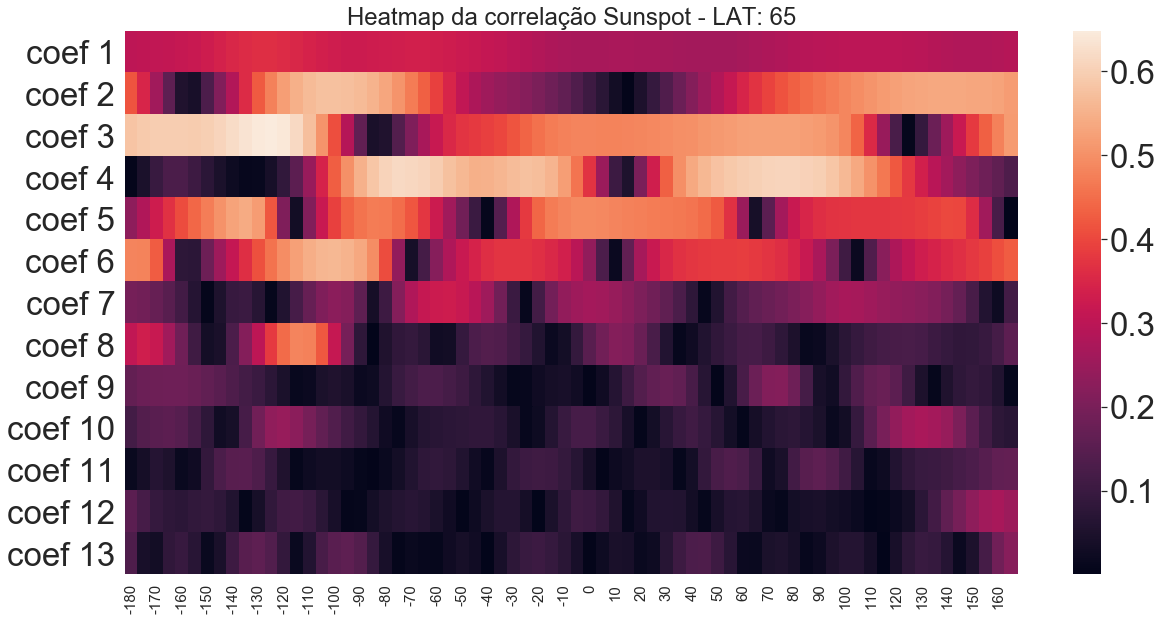

In [46]:
images_dir = '\resultado_latlonvariante'
index = ['coef '+str(i) for i in range(1,14)]
correlacao = pd.DataFrame(index=index)


for latitude in range(len(lat)):
    for i in range(len(lon)):
        correlacao[str(lon[i])] = np.array(corr_geral_rsn[latitude][i]).reshape(13,1)
  
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xticks(lon)
    ax.set_xticklabels(lons_str, fontsize=15)
    
    sns.set(font_scale=3)
    graph = sns.heatmap(abs(correlacao), ax=ax)
    ax.set_title('Heatmap da correlação Sunspot - LAT: '+str(lat[latitude]), fontdict={'fontsize':24})
    #fig.savefig(f"resultado_latlonvariante/f10.7_"+str(lat[latitude])+".png")
    

In [29]:
correlacao

<function __main__.correlacao(TEC_f)>